In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from scipy import stats

import hazelbean as hb
L = hb.get_logger()

import seaborn as sns
import matplotlib 
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import gdal

# Data description and sources

## 1. Crop data

### Earthstat (Monfreda 2008)
Coupled crop data from the smallest admin level (e.g counties in the US, régions in FR) worldwide with remote sensing data on harvested area (Raman-Kutty 2008). Datasets available for 170 crops, year 2000:
* cropname_harvestedAreaHectares = cropname_harvestAreaFraction * (ha/cell@latitude)
* cropname_YieldPerHectare = yields in tons/ha 
* cropname_Production = YieldPerHectare * HarvestedAreaHectares in tons/cell


## 2. Climate data

### Wordclim version 1.4 

* Precipitation total annual rainfall [mm] 2000 (5 arcmin) #12.bib
* Temperature annual average 2000 (5 arcmin) #1.bib


## 3. Demographic

### GDP from Worldbank WDI

* GDP 2000 (per country)

### Nordhaus Geoecon

* GDP 2000 (5 arcmin from lat/lon excel table)

### min_to_market from GRC: Werberg 2016

* min_to_market (5 arcmin)

### CIESIN Population GPW v 4.1

* pop 2000 (30 sec upsampled) /!\ TO DO Redownload this from [http://sedac.ciesin.columbia.edu/data/collection/gpw-v4](http://sedac.ciesin.columbia.edu/data/collection/gpw-v4) Source: Center for International Earth Science Information Network - CIESIN - Columbia University. 2017. Gridded Population of the World, Version 4 (GPWv4): Population Count, Revision 10. Palisades, NY: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/H4PG1PPM. Accessed DAY MONTH YEAR.

## 4. Soil

### GAEZ [gaez.fao.org/ > sutainability and potential yield > Land resources > Soil resources ]  /!\ TO DO: document these variables from the website

* workability conditions
* toxicity conditions
* crop suitability
* irrigated land %
* rooting_conditions
* protected_areas
* oxygen_availability
* nutrient_retention
* nutrient_availability
* excess_salts
* protected area


## 5. Cartographic

### Developped by Justin

* country ids + country names from [https://www.naturalearthdata.com/downloads/](https://www.naturalearthdata.com/downloads/) rasterized using midpoint approach.
* [ha/cell @ latitude] layer to avoid projection (e.g from arcmin to km2) ha_per_cell_5min - created based on latitude

## 6. Topographic

### Worldclim 1.4

* slope (5 arcmin) 
* elevation (5 arcmin)

# Load data

In [4]:
L.info('Loading data')
crop_types_df = pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/aggregate_crops_by_type/aggregated_crop_data.csv')
L.info('Data loaded (1/2)')
df_land = pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/create_baseline_regression_data/baseline_regression_data.csv')
L.info('All data loaded')

df = crop_types_df.merge(df_land,how='outer',on='pixel_id')
L.info('Data merged')


# For this purpose, we remove the calories_per_ha per crop type columns
df = df.drop(labels=['c3_annual_calories_per_ha', 'c3_perennial_calories_per_ha',
       'c4_annual_calories_per_ha', 'c4_perennial_calories_per_ha',
       'nitrogen_fixer_calories_per_ha'], axis=1)

Loading data              --- 2018-07-20 09:55:05,568 --- unnamed_logger INFO


Data loaded (1/2)              --- 2018-07-20 09:55:07,607 --- unnamed_logger INFO


All data loaded              --- 2018-07-20 09:55:12,716 --- unnamed_logger INFO


Data merged              --- 2018-07-20 09:55:14,549 --- unnamed_logger INFO


In [5]:
df.columns

Index(['pixel_id', 'calories_per_ha', 'Unnamed: 0', 'country_ids',
       'ha_per_cell_5m', 'bio12', 'bio1', 'slope', 'altitude',
       'workability_index', 'toxicity_index', 'rooting_conditions_index',
       'protected_areas_index', 'oxygen_availability_index',
       'nutrient_retention_index', 'nutrient_availability_index',
       'excess_salts_index', 'gdp_2000', 'gdp_per_capita_2000_5m',
       'minutes_to_market_5m', 'pixel_id_float', 'land_mask', 'lat', 'lon'],
      dtype='object')

#### Save a final test sample!

In [ ]:
x = baseline_df.drop(['calories_per_cell'], axis=1)
y = baseline_df['calories_per_cell']

X_train, X_test, y_train, y_test = train_test_split(x, y)

# Dataset exploration

In [9]:
#pd.options.display.max_rows = 999
df.sort_values('calories_per_ha') # Lots of NaN ?
df['calories_per_ha'].describe()

count    2.197390e+06
mean     7.788024e+06
std      2.067677e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.955132e+06
max      2.797645e+08
Name: calories_per_ha, dtype: float64

In [10]:
df['calories_per_ha'].isnull().sum()

17154

In [18]:
print('Over ',len(df['calories_per_ha']),' land pixels, calories_per_ha has ',
      df['calories_per_ha'].isnull().sum(), ' ( ',
      (df['calories_per_ha'].isnull().sum()/len(df['calories_per_ha']))*100,
      ' % Null values.')


Over  2214544  land pixels, calories_per_ha has  17154  (  0.774606420102739  % Null values.


In [22]:
print('df',
      '# pixels (rows): {}'.format(df.shape[0]),
      '# features: {}'.format(df.shape[1]-1),
      '',
      'Cols:',str(df.columns),
      '',
      '% Pixels with 0 ag: {:.1%}'.format(df[df['calories_per_ha']==0].shape[0]/df.shape[0]),
      sep="\n")

df
# pixels (rows): 2214544
# features: 19

Cols:
Index(['Unnamed: 0', 'country_ids', 'ha_per_cell_5m', 'bio12', 'bio1', 'slope',
       'altitude', 'workability_index', 'toxicity_index',
       'rooting_conditions_index', 'oxygen_availability_index',
       'nutrient_retention_index', 'nutrient_availability_index',
       'excess_salts_index', 'gdp_2000', 'gdp_per_capita_2000_5m',
       'minutes_to_market_5m', 'pixel_id', 'land_mask', 'calories_per_ha'],
      dtype='object')

% Pixels with 0 ag: 72.7%


### dropna

In [9]:
df = df.dropna()
len(df) 

#looks like these are only the 0.7% NaN in calories_per_ha

2197390

/Users/charlotteweil1/anaconda/envs/Justin/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


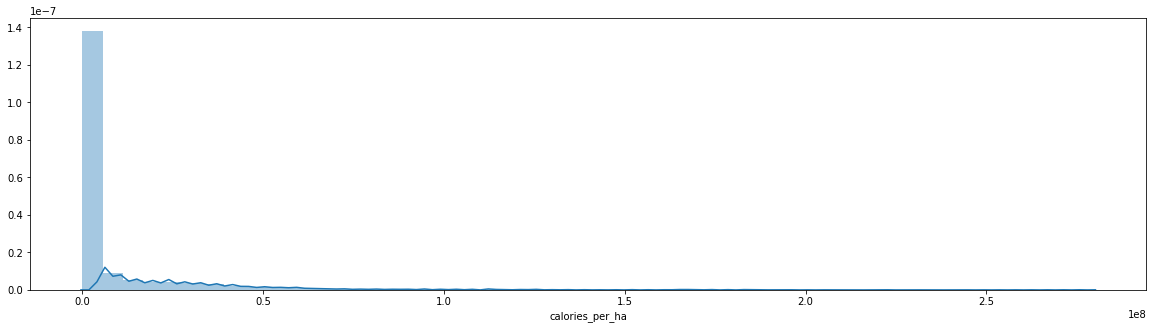

In [27]:
fig,ax = plt.subplots(figsize=(20,5));
sns.distplot(df['calories_per_ha'],ax=ax);

/Users/charlotteweil1/anaconda/envs/Justin/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


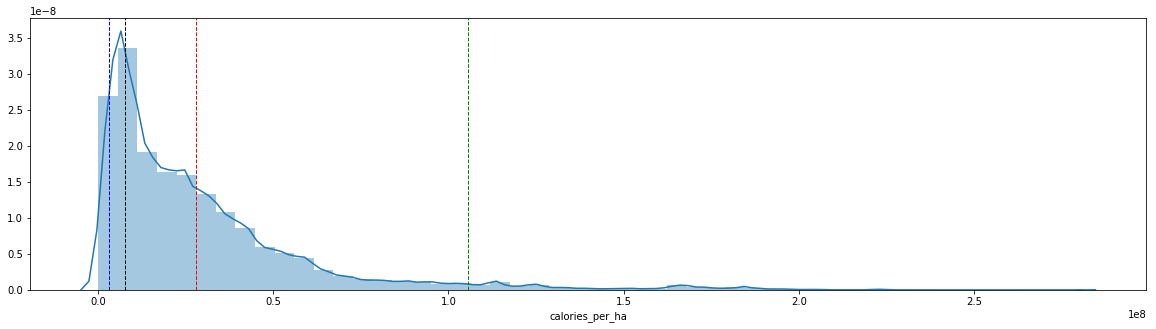

In [30]:
fig,ax = plt.subplots(figsize=(20,5));
sns.distplot(df[df['calories_per_ha']!=0]['calories_per_ha'],ax=ax);

#Lines at mean, 75%, 90%, and 99%
plt.axvline(df['calories_per_ha'].mean(), color='k', linestyle='dashed', linewidth=1);
plt.axvline(df['calories_per_ha'].quantile(0.75), color='b', linestyle='dashed', linewidth=1);
plt.axvline(df['calories_per_ha'].quantile(0.9), color='r', linestyle='dashed', linewidth=1);
plt.axvline(df['calories_per_ha'].quantile(0.99), color='g', linestyle='dashed', linewidth=1);

##### Should we Remove top 1% of baseline_df['calories_per_cell'] (outliers?)
 ##### Does Justin has an easy way to look at where they are from pixel_id (map functions?)

/Users/charlotteweil1/anaconda/envs/Justin/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


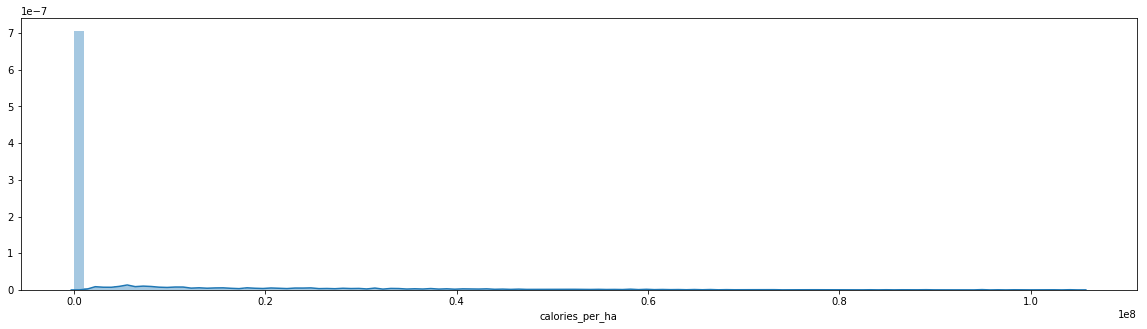

In [33]:
fig,ax = plt.subplots(figsize=(20,5));
sns.distplot(df[df['calories_per_ha']<df['calories_per_ha'].quantile(0.99)]['calories_per_ha'],ax=ax,bins=100);

In [39]:
only_ag = df[df['calories_per_ha']!=0]

/Users/charlotteweil1/anaconda/envs/Justin/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


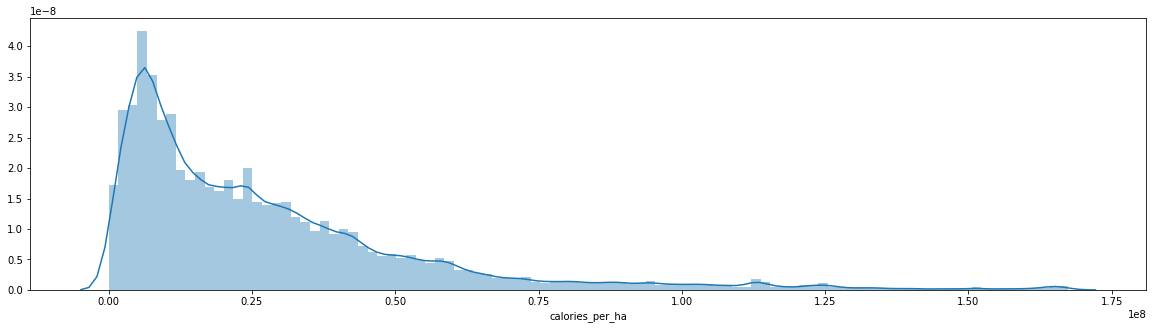

In [40]:
fig,ax = plt.subplots(figsize=(20,5));
sns.distplot(only_ag[only_ag['calories_per_ha']<only_ag['calories_per_ha'].quantile(0.99)]['calories_per_ha'],ax=ax,bins=100);

/Users/charlotteweil1/anaconda/envs/Justin/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


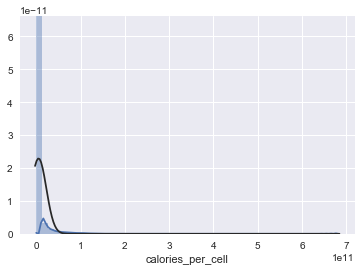

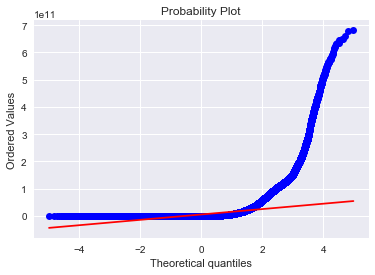

In [160]:
## Check assumption of normality: 
## * Histogram - Kurtosis and skewness.
## Normal probability plot - Data distribution should closely follow the diagonal that represents the normal distribution.

sns.distplot(baseline_df['calories_per_cell'], fit=norm);
fig = plt.figure()
res = stats.probplot(baseline_df['calories_per_cell'], plot=plt)

##### Problem: distribution super highly skewed left, stats test makes assumptions of normality.. :/

### Data transformation : log (calories_per_cell)

##### But first create a binary (has_ag) column for pixels where calories = 0 (because log doesn't deal with zeros)

In [396]:
baseline_df['has_ag'] = pd.Series(len(baseline_df['calories_per_cell']), index=baseline_df.index)
baseline_df['has_ag'] = 0 
baseline_df.loc[baseline_df['calories_per_cell']>0,'has_ag'] = 1
baseline_df


calories_per_cell  precip  temperature      gdp_2000  \
842158        1.219599e+08   299.0          0.0    768.882875   
1786473       0.000000e+00  3466.0        256.0   4385.907571   
587201        0.000000e+00   518.0          0.0   3870.412333   
1764461       0.000000e+00  1306.0        242.0    206.567174   
1919691       0.000000e+00  1239.0        202.0      0.000000   
1589400       2.563720e+09  2591.0        262.0   1234.135259   
1391963       7.436787e+09   929.0        189.0   1127.726124   
958310        0.000000e+00    73.0         18.0    768.882875   
2027569       0.000000e+00   169.0        204.0   3007.373934   
862612        2.494609e+07   626.0         25.0  33372.029454   
1340712       4.373264e+06   634.0          6.0   1127.726124   
1564472       0.000000e+00    73.0        276.0    559.419921   
1921039       0.000000e+00  1485.0        257.0    983.426445   
1480380       0.000000e+00    25.0        217.0   1595.766665   
1227421       5.950329e+09   638.0        167.0  40945.633827   
247886        0.000000e+00  1686.0          0.0  28962.040538   
1492970       0.000000e+00    32.0        264.0    559.419921   
1018318       4.133035e+09   451.0         82.0  40945.633827   
1997579       0.000000e+00   511.0        214.0    675.798307   
517218        0.000000e+00   714.0          0.0   3870.412333   
389165        0.000000e+00   442.0          0.0  33372.029454   
470551        0.000000e+00   622.0         19.0   3870.412333   
2141587       6.589011e+10   803.0        173.0   5398.717829   
254776        0.000000e+00   451.0          0.0   3870.412333   
633640        1.103318e+09   491.0          0.0   3870.412333   
1645579       1.348770e+10   973.0        255.0    552.186892   
694563        2.797888e+09   640.0         52.0   3870.412333   
1935392       3.562118e+08   751.0         42.0   2345.647384   
1660504       6.373455e+08   974.0        275.0    365.606546   
653625        0.000000e+00   607.0          0.0  33372.029454   
311102        0.000000e+00   476.0          0.0   3870.412333   
1088003       0.000000e+00    60.0         88.0   1127.726124   
311937        0.000000e+00   290.0          0.0   3870.412333   
751810        3.711581e+09   297.0         36.0   2343.537035   
109469        0.000000e+00  1249.0          0.0  28962.040538   
1804229       0.000000e+00  2843.0        256.0   4385.907571   
1740151       2.837296e+09   363.0        263.0    504.498647   
1897048       1.809345e+09  1177.0        205.0      0.000000   
279203        0.000000e+00   344.0          0.0   3870.412333   
1977780       6.097754e+08  1330.0        239.0   4385.907571   
882407        6.985727e+09   335.0         53.0  40945.633827   
45048         0.000000e+00   353.0          0.0  28962.040538   
137126        0.000000e+00   306.0          0.0   3870.412333   
770747        0.000000e+00   537.0          0.0   3870.412333   
1905874       0.000000e+00  2097.0        254.0   4385.907571   
496394        0.000000e+00   308.0          0.0  33372.029454   
40720         0.000000e+00   278.0          0.0  28962.040538   
599930        0.000000e+00   546.0          0.0  33372.029454   
1642606       1.510008e+08   807.0        270.0    365.606546   
475108        0.000000e+00   453.0          0.0   3870.412333   
2105269       0.000000e+00    60.0        157.0   3007.373934   
204427        0.000000e+00   377.0          0.0   3870.412333   
1301482       1.958634e+10  1259.0        158.0   1127.726124   
503136        0.000000e+00   527.0          0.0   3870.412333   
1575389       0.000000e+00    90.0        218.0    766.138663   
345916        0.000000e+00   289.0          0.0   3870.412333   
2053680       0.000000e+00   242.0        250.0  30853.887611   
896732        5.445874e+07   328.0          0.0    768.882875   
1512731       0.000000e+00     5.0        269.0    559.419921   
1581924       0.000000e+00    70.0        295.0    365.606546   
2079120       0.000000e+00   286.0        20

In [ ]:
baseline_df.loc[baseline_df['has_ag']==1,'calories_per_cell'] = np.log(baseline_df['calories_per_cell'])

/Users/charlotteweil1/anaconda/envs/Justin/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


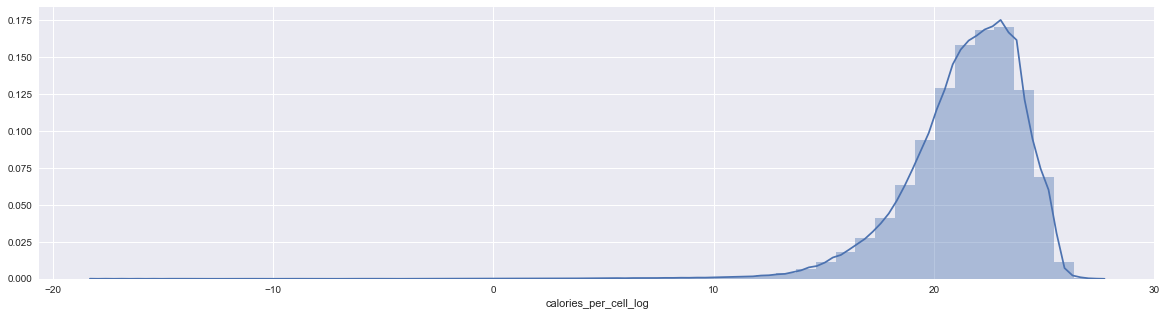

In [233]:
fig,ax = plt.subplots(figsize=(20,5))
sns.distplot(baseline_df['calories_per_cell_log'],ax=ax);

In [235]:
baseline_df['calories_per_cell_log'].describe()

count    918540.000000
mean         21.384647
std           2.704803
min         -17.821341
25%          20.047437
50%          21.794622
75%          23.262319
max          27.247673
Name: calories_per_cell_log, dtype: float64

/Users/charlotteweil1/anaconda/envs/Justin/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


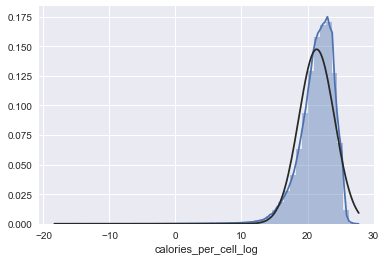

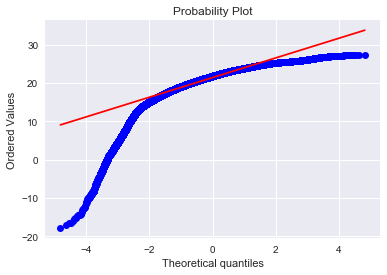

In [237]:
## Check assumption of normality: 
## * Histogram - Kurtosis and skewness.
## Normal probability plot - Data distribution should closely follow the diagonal that represents the normal distribution.

sns.distplot(baseline_df['calories_per_cell_log'], fit=norm);
fig = plt.figure()
res = stats.probplot(baseline_df['calories_per_cell_log'], plot=plt)

## Normalization

In [248]:


scaler = MinMaxScaler()

#scaled_subset_df = pd.DataFrame(scaler.fit_transform(subset_df.T), columns=subset_df.T.columns)
##Q: This normalizes the columns. Is it what I want?

scaled = pd.DataFrame(scaler.fit_transform(baseline_df), columns=baseline_df.columns)
##Q: This normalizes the rows. Is it what I want?


## Outliers out liars

In [151]:
scaled.sort_values('calories_per_cell')

calories_per_cell    precip  temperature  gdp_2000  \
0                 0.000000  0.013645     0.000000  0.000000   
1228515           0.000000  0.017658     0.000000  0.010677   
1228514           0.000000  0.017458     0.000000  0.010677   
1228513           0.000000  0.017257     0.000000  0.010677   
1228512           0.000000  0.016956     0.000000  0.010677   
1228511           0.000000  0.016956     0.000000  0.010677   
1228510           0.000000  0.016655     0.000000  0.010677   
1228509           0.000000  0.016655     0.000000  0.010677   
1228516           0.000000  0.017759     0.000000  0.010677   
1228508           0.000000  0.016454     0.000000  0.010677   
1228506           0.000000  0.016053     0.000000  0.010677   
1228505           0.000000  0.015852     0.000000  0.010677   
1228504           0.000000  0.015551     0.000000  0.010677   
1228503           0.000000  0.015351     0.000000  0.010677   
1228502           0.000000  0.015351     0.000000  0.010677   
1228501           0.000000  0.015150     0.000000  0.010677   
1228500           0.000000  0.015050     0.000000  0.010677   
1228507           0.000000  0.016153     0.000000  0.010677   
1228499           0.000000  0.014749     0.000000  0.010677   
1228522           0.000000  0.019063     0.000000  0.010677   
1228532           0.000000  0.021070     0.000000  0.010677   
1228581           0.000000  0.035116     0.000000  0.010677   
1228580           0.000000  0.034213     0.000000  0.010677   
1228579           0.000000  0.033210     0.000000  0.010677   
1228578           0.000000  0.033009     0.000000  0.010677   
1228577           0.000000  0.032808     0.000000  0.010677   
1228576           0.000000  0.032708     0.000000  0.010677   
1228575           0.000000  0.032407     0.000000  0.010677   
1228524           0.000000  0.019364     0.000000  0.010677   
1228574           0.000000  0.032006     0.000000  0.010677   
1228572           0.000000  0.031805     0.000000  0.010677   
1228571           0.000000  0.031604     0.000000  0.010677   
1228570           0.000000  0.031203     0.000000  0.010677   
1228569           0.000000  0.031103     0.000000  0.010677   
1228568           0.000000  0.030601     0.000000  0.010677   
1228567           0.000000  0.030099     0.000000  0.010677   
1228566           0.000000  0.029698     0.000000  0.010677   
1228573           0.000000  0.032006     0.000000  0.010677   
1228582           0.000000  0.034915     0.000000  0.010677   
1228498           0.000000  0.014648     0.000000  0.010677   
1228496           0.000000  0.014448     0.000000  0.010677   
1228475           0.000000  0.011538     0.000000  0.010677   
1228474           0.000000  0.011538     0.000000  0.010677   
1228473           0.000000  0.011438     0.000000  0.010677   
1228472           0.000000  0.011337     0.000000  0.010677   
1228471           0.000000  0.011137     0.000000  0.010677   
1228470           0.000000  0.011137     0.000000  0.010677   
1228469           0.000000  0.011036     0.000000  0.010677   
1228476           0.000000  0.011638     0.000000  0.010677   
1228468           0.000000  0.010936     0.000000  0.010677   
1228466           0.000000  0.011036     0.000000  0.010677   
1228465           0.000000  0.010936     0.000000  0.010677   
1228464           0.000000  0.010936     0.000000  0.010677   
1228463           0.000000  0.010735     0.000000  0.010677   
1228462           0.000000  0.010434     0.000000  0.010677   
1228461           0.000000  0.010133     0.000000  0.010677   
1228460           0.000000  0.010133     0.000000  0.010677   
1228467           0.000000  0.010936     0.000000  0.010677   
1228497           0.000000  0.014347     0.000000  0.010677   
1228477           0.000000  0.011939     0.000000  0.010677   
1228479           0.000000  0.012140     0.000000  0.010677   
1228495           0.000000  0.014147     0.000000  0.010677   
1228494           0.000000  0.014147    

## Subset
Representative (?) sample for faster computation

In [10]:
subset = df.sample(frac=0.01, replace=False, weights=None, random_state=None, axis=0)

In [11]:
df = subset

## Visualizations

In [61]:
baseline_df = baseline_df.sort_values(by=['calories_per_cell'])


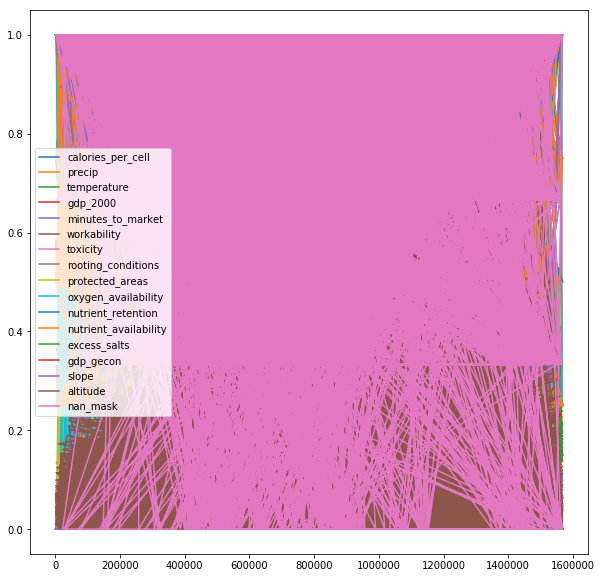

In [64]:
baseline_df.plot(figsize=(10,10))

### Features distributions

21974

In [41]:
df.columns

Index(['Unnamed: 0', 'country_ids', 'ha_per_cell_5m', 'bio12', 'bio1', 'slope',
       'altitude', 'workability_index', 'toxicity_index',
       'rooting_conditions_index', 'oxygen_availability_index',
       'nutrient_retention_index', 'nutrient_availability_index',
       'excess_salts_index', 'gdp_2000', 'gdp_per_capita_2000_5m',
       'minutes_to_market_5m', 'pixel_id', 'land_mask', 'calories_per_ha'],
      dtype='object')

In [14]:
features_list = ['ha_per_cell_5m', 'bio12', 'bio1', 'slope',
       'altitude', 'workability_index', 'toxicity_index',
       'rooting_conditions_index', 'oxygen_availability_index',
       'nutrient_retention_index', 'nutrient_availability_index',
       'excess_salts_index', 'gdp_2000', 'gdp_per_capita_2000_5m',
       'minutes_to_market_5m', 'pixel_id', 'land_mask', 'calories_per_ha']

LinAlgError: singular matrix

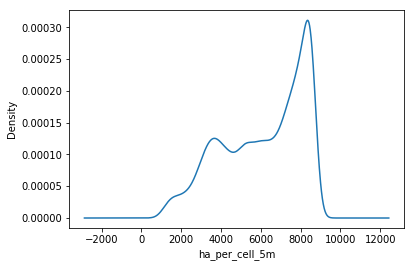

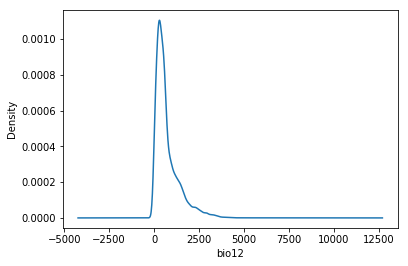

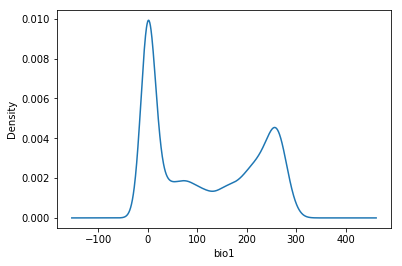

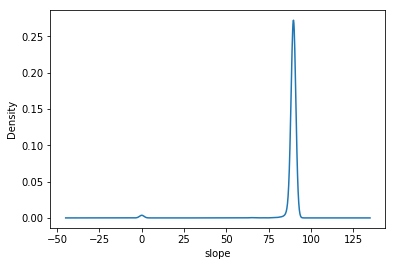

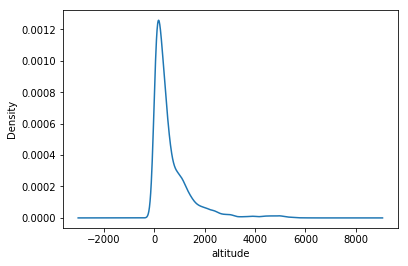

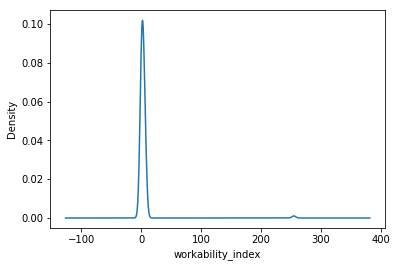

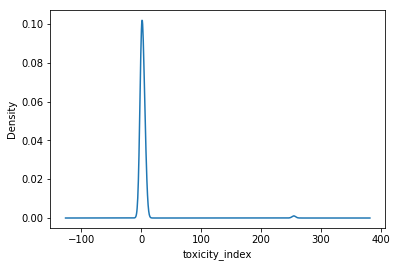

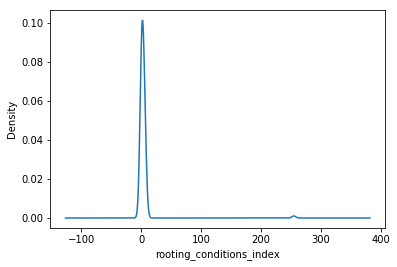

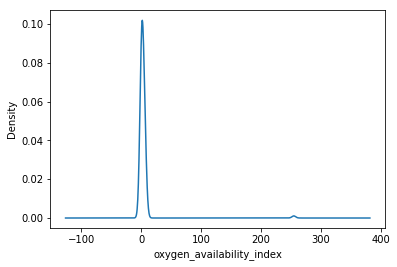

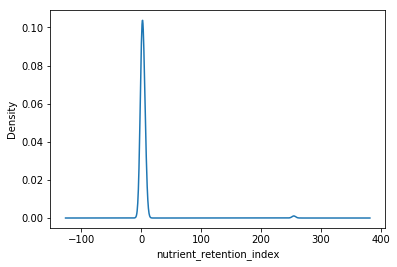

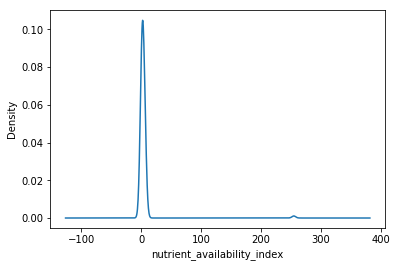

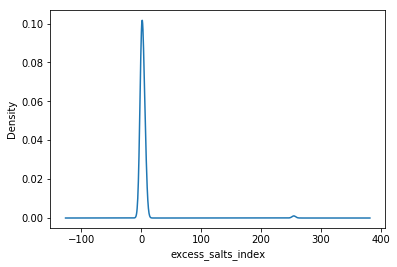

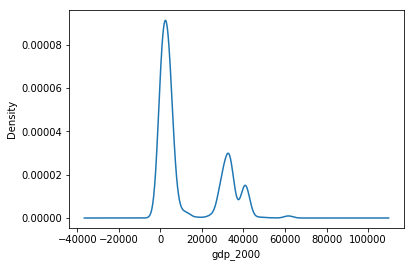

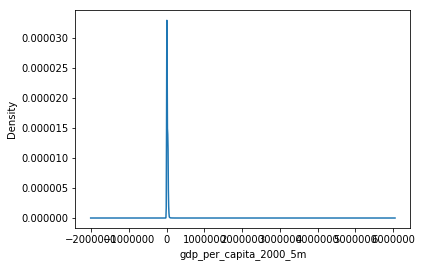

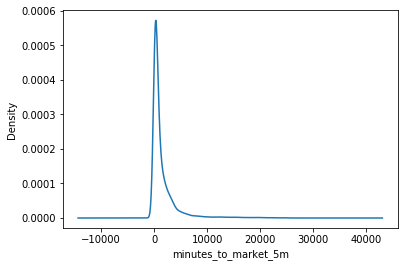

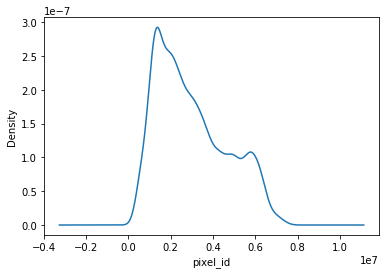

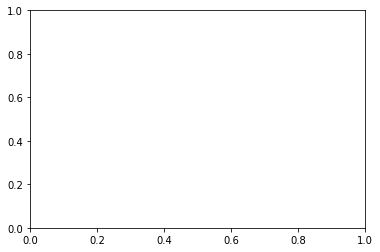

In [15]:
for var in features_list:
    fig,ax = plt.subplots()
    df[var].plot(kind='kde',ax=ax);
    ax.set_xlabel(var);
    
    # Now all the indices are binary 0/1 where before it was 0,0.25,.5,.75,1...

### Calories_per_ha relationships

IndexError: index 4 is out of bounds for axis 1 with size 4

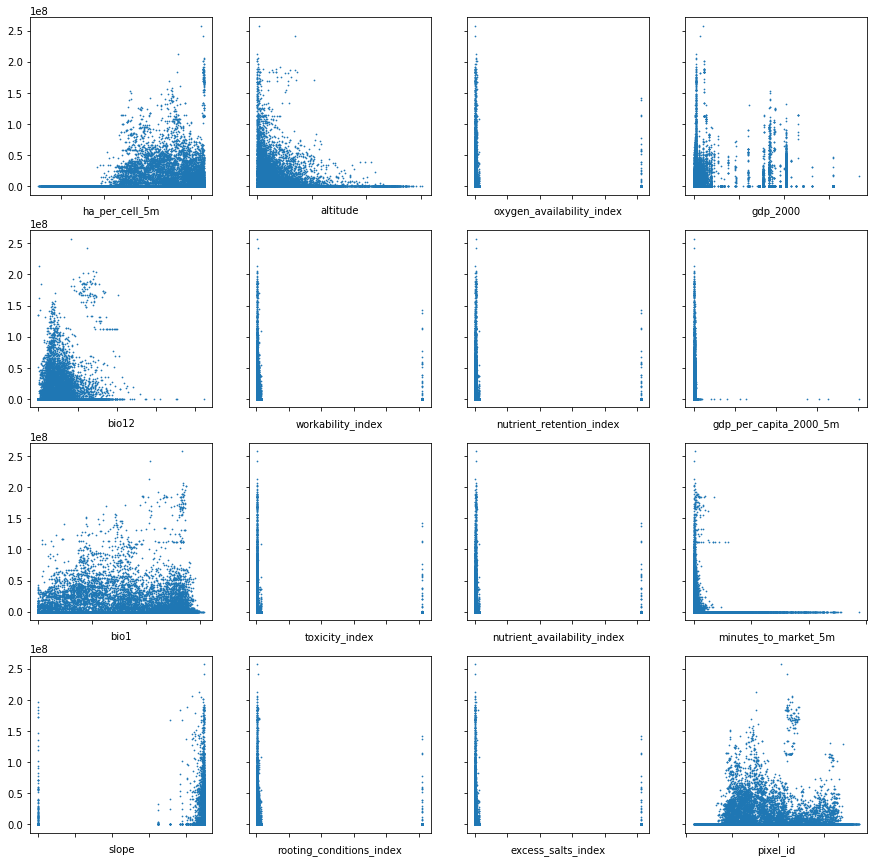

In [16]:
fig,axes = plt.subplots(4, 4, sharey=True,figsize=(15,15))

i =0
j =0
for var in features_list:

    axes[i,j].scatter(data=df,x=var, y='calories_per_ha',s=.5);
    axes[i,j].set_xlabel(var);
    axes[i,j].set_xticklabels([]);

    if i < 3:
        i+=1
    else:
        i=0
        j+=1
        
## To do also with scaled data

In [41]:
df['nutrient_availability_index'] = df['nutrient_availability_index'].replace({255:np.nan})

In [42]:
df

1180453    2.0
1059084    3.0
1421941    1.0
1952284    2.0
327723     6.0
1904102    4.0
1433994    4.0
1727516    2.0
1154112    1.0
1781442    7.0
2034072    1.0
111116     6.0
2033033    1.0
369513     6.0
1655727    2.0
849351     6.0
2127012    3.0
1845399    2.0
1542799    1.0
401676     6.0
1436668    1.0
1154606    1.0
449349     6.0
390307     3.0
2138652    1.0
514096     2.0
815509     1.0
1903169    2.0
849376     3.0
1063515    1.0
          ... 
2040128    2.0
1321456    2.0
1347059    1.0
98897      6.0
841812     6.0
138858     6.0
1686811    1.0
1332348    1.0
1448220    1.0
530913     2.0
191168     6.0
2033063    1.0
775302     3.0
1579315    1.0
611880     6.0
400008     3.0
343968     1.0
255539     6.0
1737235    1.0
1051588    1.0
1665091    3.0
643384     6.0
1228396    1.0
1749086    3.0
1232542    6.0
1407039    1.0
1195050    2.0
2199639    2.0
1855553    1.0
543081     2.0
Name: nutrient_availability_index, Length: 21974, dtype: float64

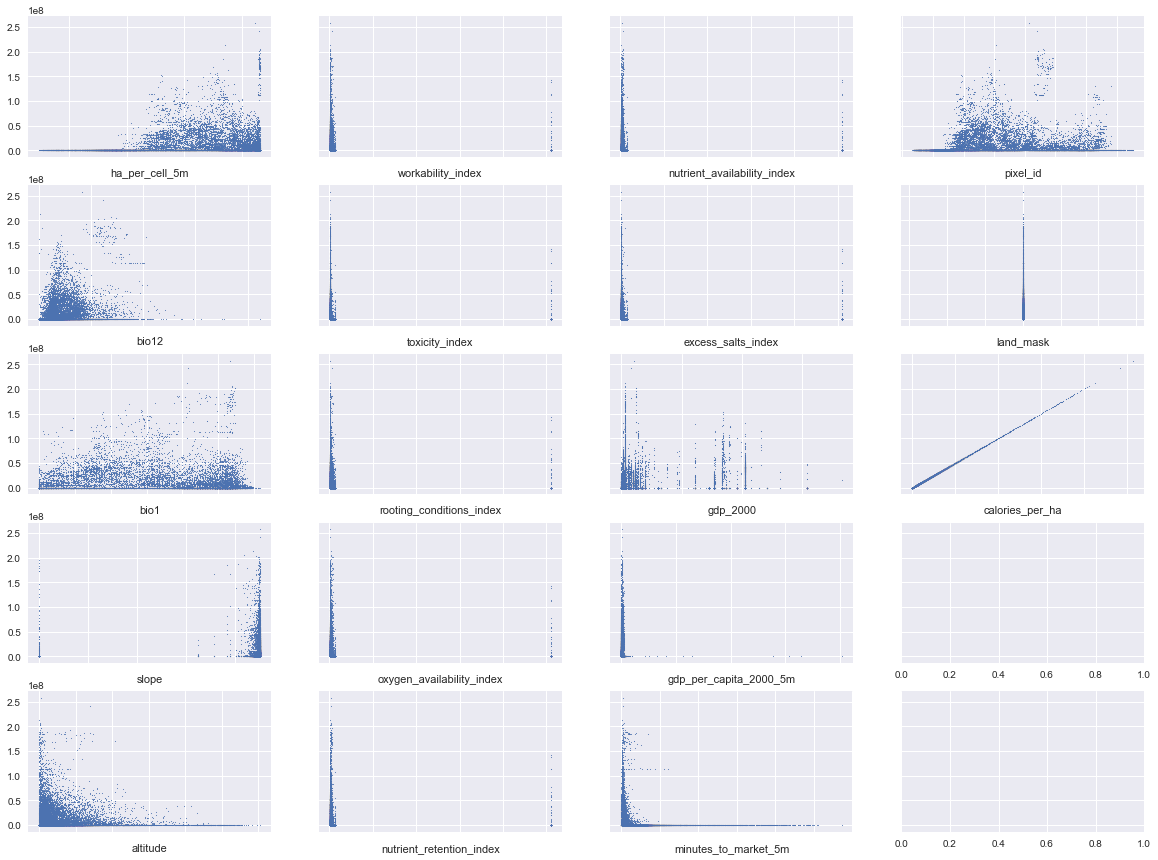

In [20]:
fig,axes = plt.subplots(5, 4, sharey=True,figsize=(20,15))

i =0
j =0
for var in features_list:

    axes[i,j].scatter(data=df,x=var, y='calories_per_ha',s=.5);
    axes[i,j].set_xlabel(var);
    axes[i,j].set_xticklabels([]);

    if i < 4:
        i+=1
    else:
        i=0
        j+=1
        
## To do also with scaled data

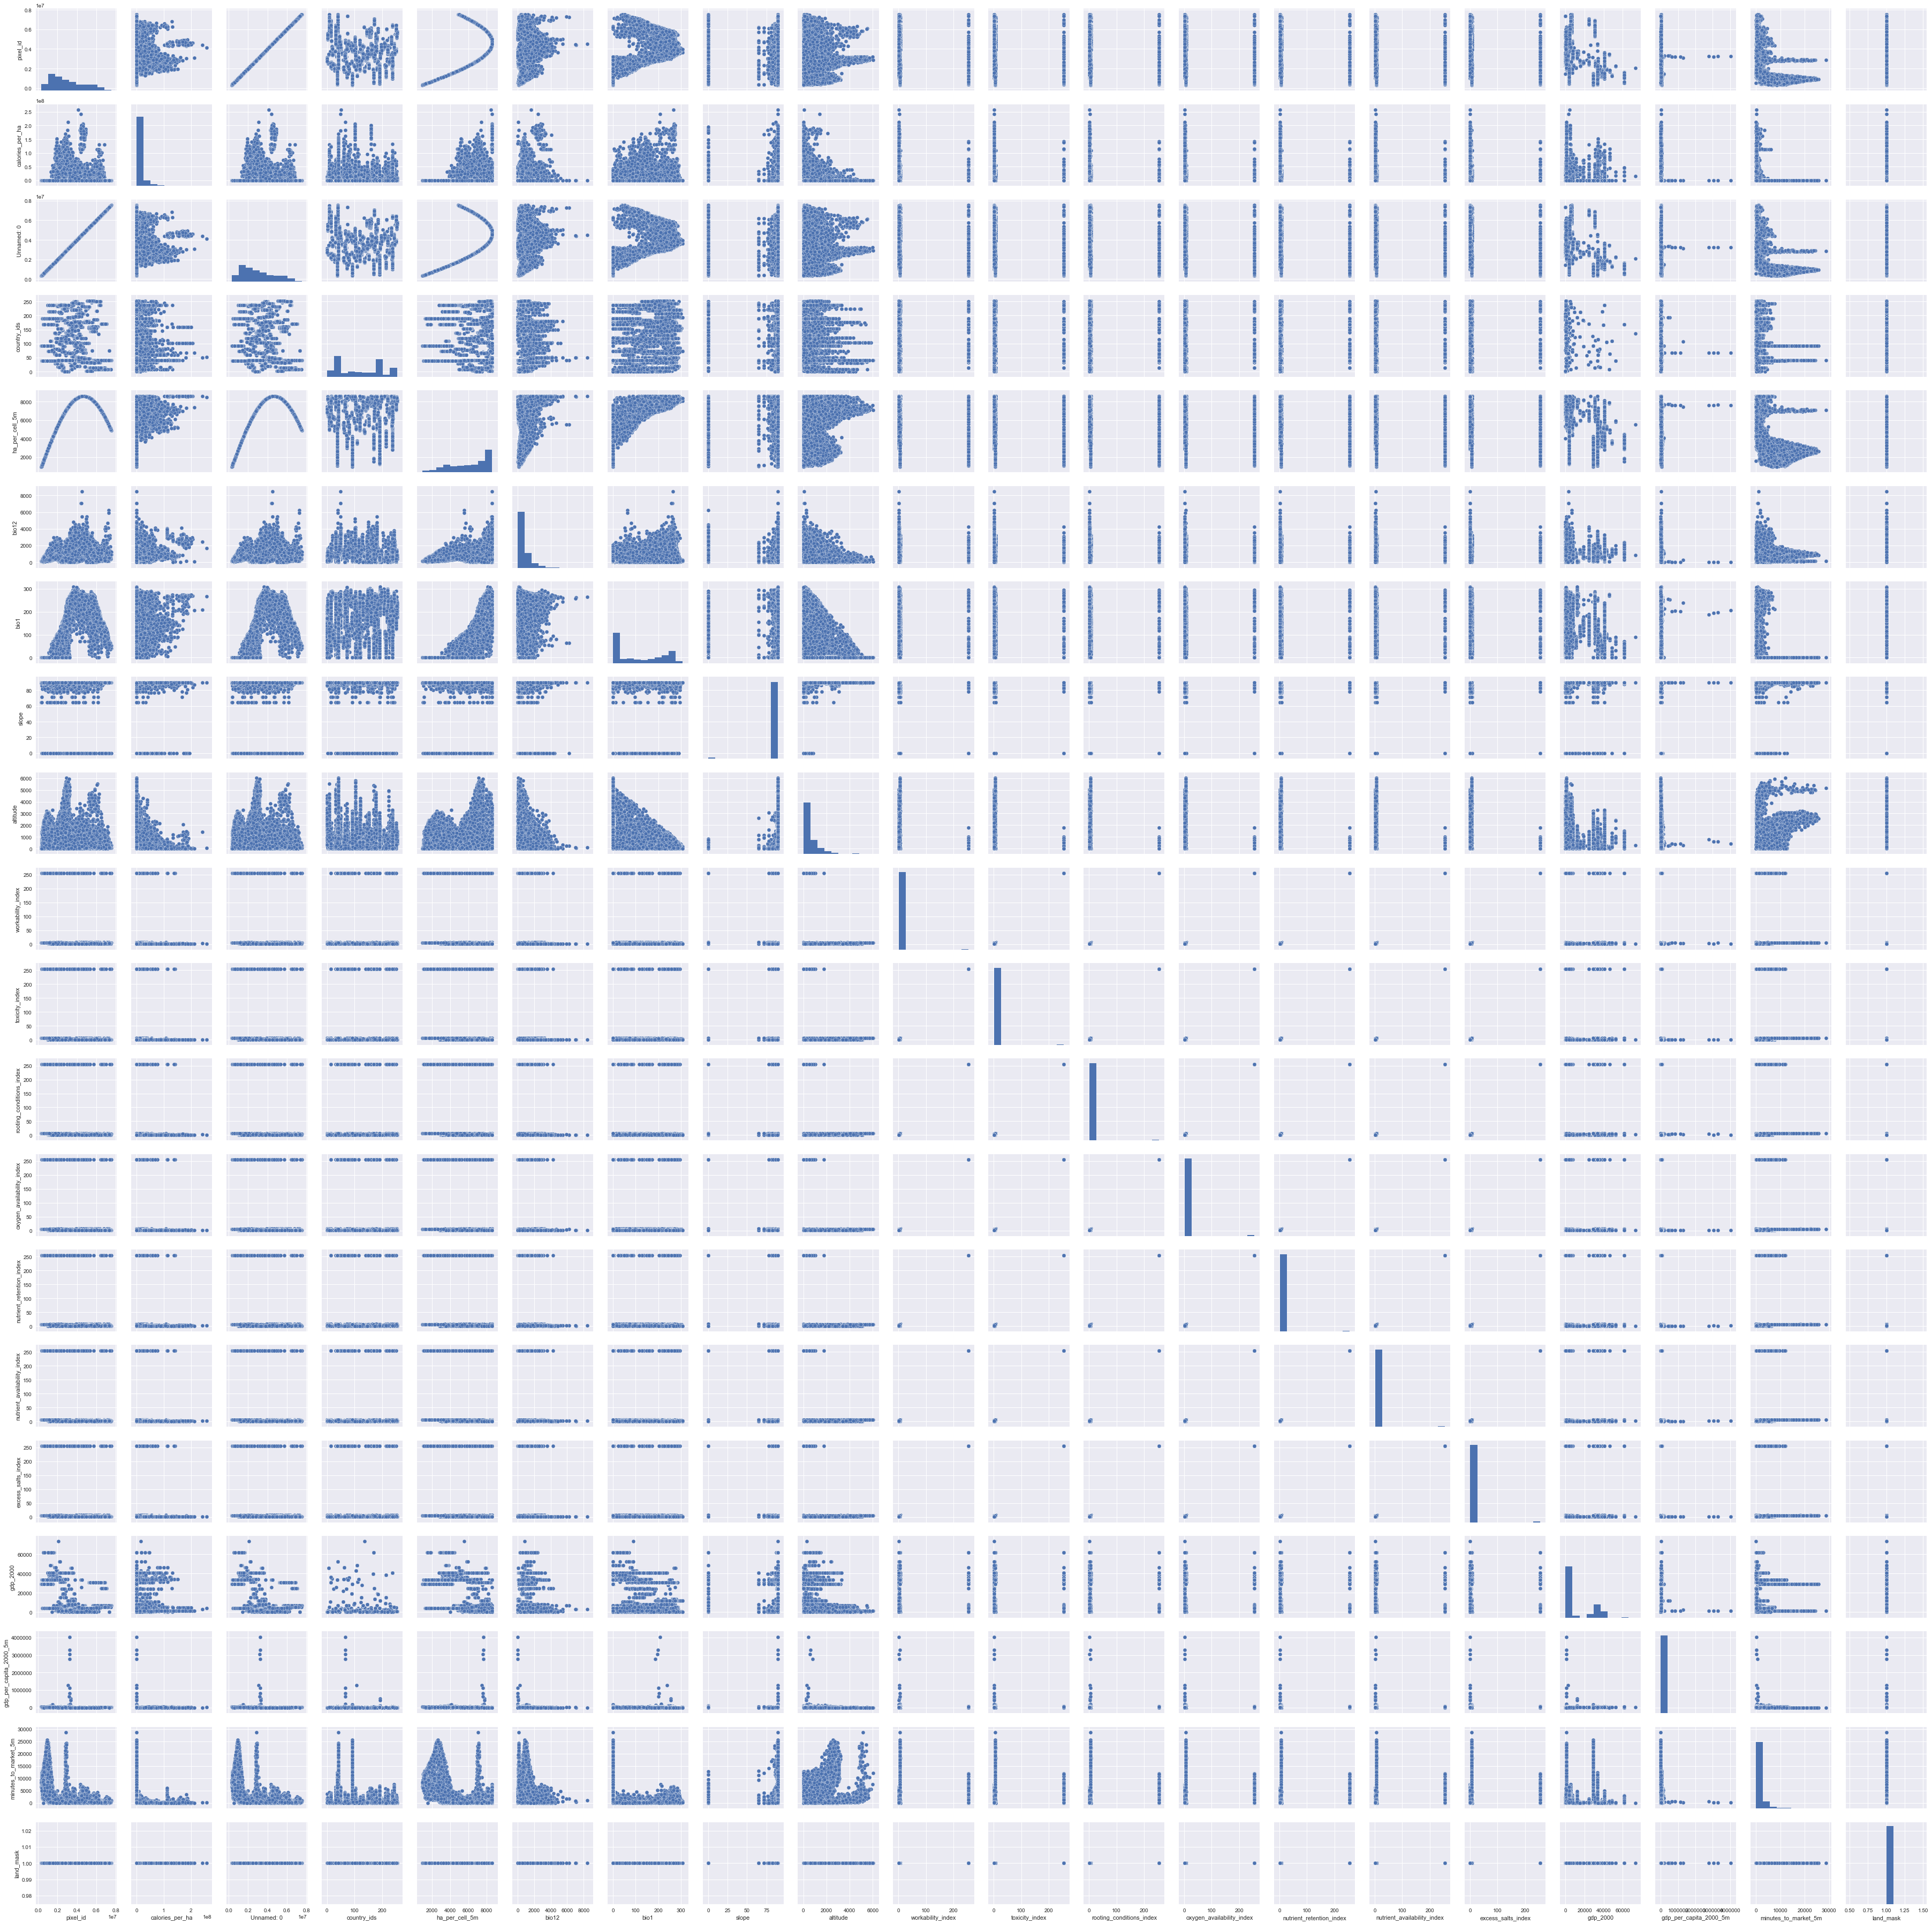

In [17]:
sns.set()
cols = df.columns
sns.pairplot(df[cols], size = 2.5);

IndexError: index 4 is out of bounds for axis 1 with size 4

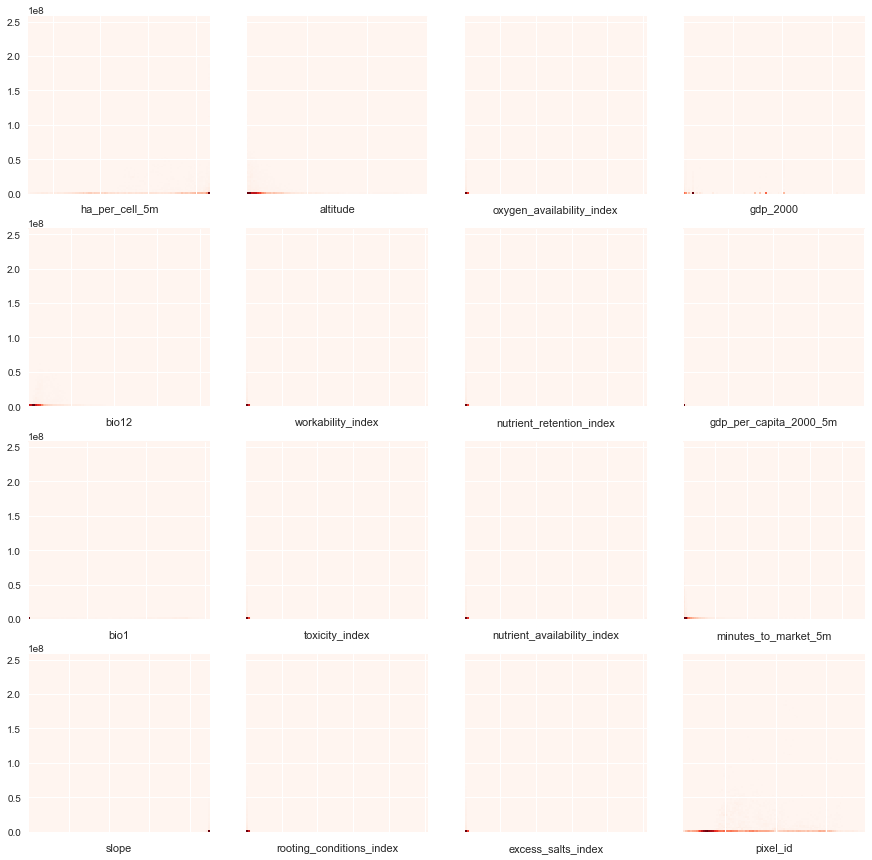

In [18]:
fig,axes = plt.subplots(4, 4, sharey=True,figsize=(15,15))

i =0
j =0
for var in features_list:

    axes[i,j].hist2d(data=df,x=var, y='calories_per_ha',bins=(100, 100), cmap=plt.cm.Reds);
    axes[i,j].set_xlabel(var);
    axes[i,j].set_xticklabels([]);

    if i < 3:
        i+=1
    else:
        i=0
        j+=1

##### Relationship with categorical feature (to do with climate zone)

In [ ]:
#box plot overall/categorical var
var = 'climatezone'
data = pd.concat([df_train['calories_per_cell'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='calories_per_cell', data=data)
fig.axis(ymin=0, ymax=800000);

### Correlation matrix

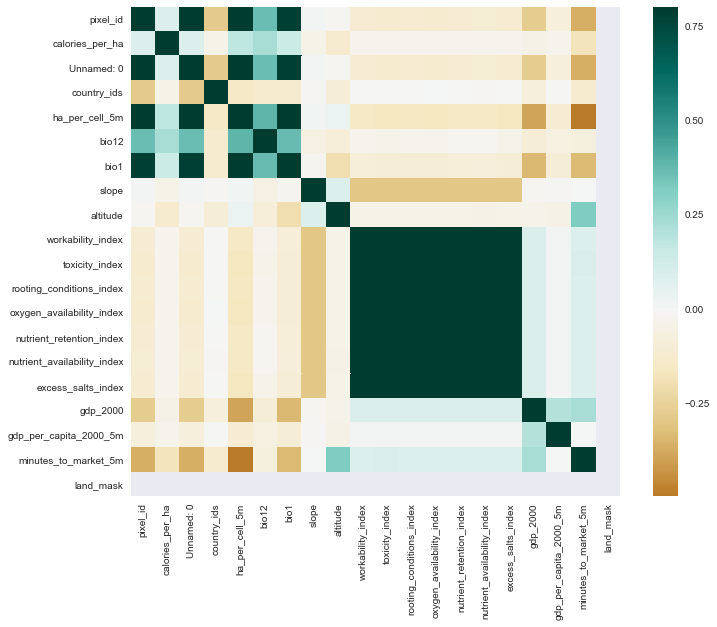

In [21]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,cmap=("BrBG"),center=0);

* 'nutrient retention' and 'nutrient availability' redundant features (corr=0.87)
* 

In [68]:
baseline_df.corr(method='pearson', min_periods=1)

calories_per_cell    precip  temperature  gdp_2000  \
calories_per_cell               1.000000  0.131158     0.036231  0.040191   
precip                          0.131158  1.000000     0.317782 -0.099420   
temperature                     0.036231  0.317782     1.000000 -0.319273   
gdp_2000                        0.040191 -0.099420    -0.319273  1.000000   
minutes_to_market              -0.197098  0.185597     0.132374 -0.048031   
workability                     0.114709  0.106688    -0.079534  0.076182   
toxicity                        0.086120  0.236717    -0.078342  0.113278   
rooting_conditions              0.123074  0.136011     0.041727  0.032737   
protected_areas                 0.062785 -0.075035     0.007914 -0.013414   
oxygen_availability            -0.001244  0.009362     0.080316  0.018149   
nutrient_retention              0.133642 -0.239673    -0.120894  0.064591   
nutrient_availability           0.150869 -0.289955    -0.150056  0.055665   
excess_salts                    0.057272  0.235731    -0.054947  0.081776   
gdp_gecon                       0.000748 -0.041228    -0.068837  0.193374   
slope                          -0.016146 -0.076620    -0.039485  0.012254   
altitude                       -0.137495 -0.161395    -0.227952 -0.067244   
nan_mask                        0.057272  0.235731    -0.054947  0.081776   

                       minutes_to_market  workability  toxicity  \
calories_per_cell              -0.197098     0.114709  0.086120   
precip                          0.185597     0.106688  0.236717   
temperature                     0.132374    -0.079534 -0.078342   
gdp_2000                       -0.048031     0.076182  0.113278   
minutes_to_market               1.000000    -0.058383 -0.063138   
workability                    -0.058383     1.000000  0.325593   
toxicity                       -0.063138     0.325593  1.000000   
rooting_conditions             -0.086285     0.858885  0.324286   
protected_areas                -0.142194     0.023161 -0.014415   
oxygen_availability            -0.068238     0.093915  0.330215   
nutrient_retention             -0.229118     0.015277  0.284066   
nutrient_availability          -0.248457    -0.000308  0.231825   
excess_salts                   -0.000935     0.180991  0.621017   
gdp_gecon                      -0.009931     0.008251  0.027011   
slope                           0.023311    -0.031378 -0.023532   
altitude                        0.034083    -0.265758 -0.016429   
nan_mask                       -0.000935     0.180991  0.621017   

                       rooting_conditions  protected_areas  \
calories_per_cell                0.123074         0.062785   
precip                           0.136011        -0.075035   
temperature                      0.041727         0.007914   
gdp_2000                         0.032737        -0.013414   
minutes_to_market               -0.086285        -0.142194   
workability                      0.858885         0.023161   
toxicity                         0.324286        -0.014415   
rooting_conditions               1.000000         0.025800   
protected_areas                  0.025800         1.000000   
oxygen_availability              0.106990         0.023905   
nutrient_retention               0.014280         0.060357   
nutrient_availability            0.018790         0.057888   
excess_salts                     0.179529        -0.007909   
gdp_gecon                       -0.005672        -0.002642   
slope                           -0.025923         0.029931   
altitude                        -0.271510        -0.044148   
nan_mask                         0.179529        -0.007909   

                       oxygen_availability  nutrient_retention  \
calories_per_cell                -0.001244            0.133642   
precip                            0.009362           -0.239673   
temperature                       0.080316           -0.120894   
gdp_2000                          0.018149      

In [125]:
cols = baseline_df.columns

cols

Index(['calories_per_cell', 'precip', 'temperature', 'gdp_2000',
       'minutes_to_market', 'workability', 'toxicity', 'rooting_conditions',
       'protected_areas', 'oxygen_availability', 'nutrient_retention',
       'nutrient_availability', 'excess_salts', 'gdp_gecon', 'slope',
       'altitude', 'nan_mask'],
      dtype='object')

/Users/charlotteweil1/anaconda/envs/Justin/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/charlotteweil1/anaconda/envs/Justin/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


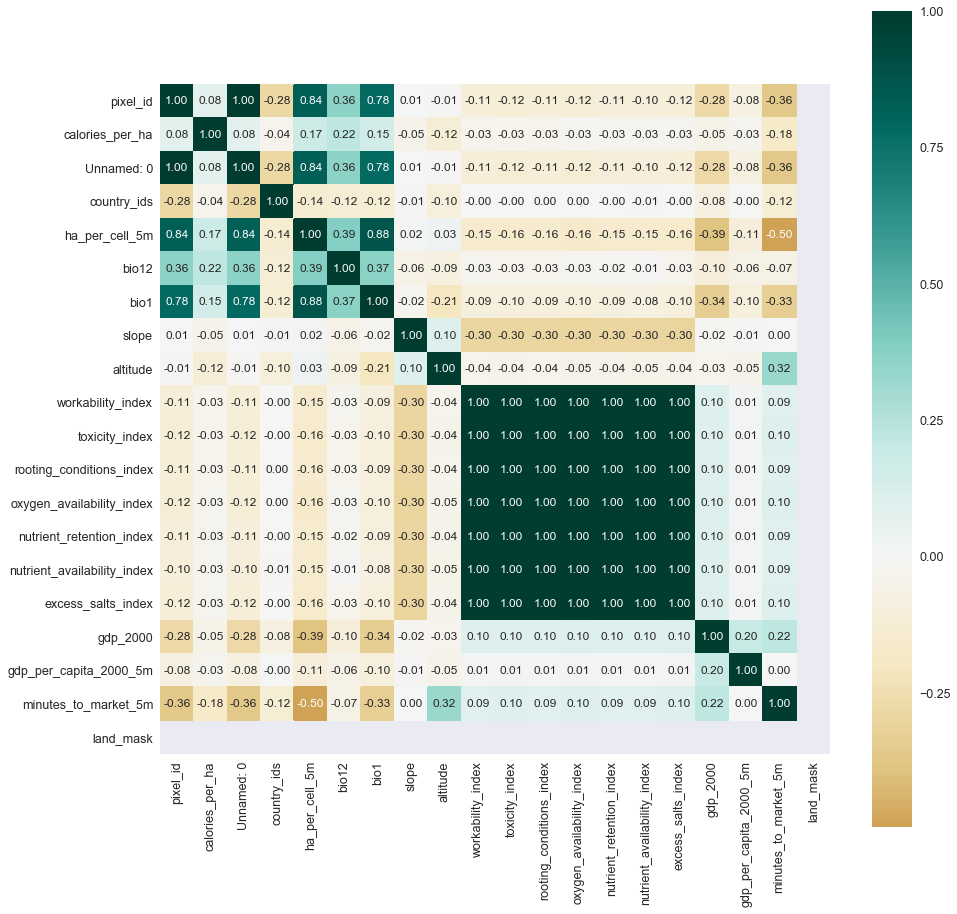

In [25]:
#correlation matrix

cols = df.columns
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)

fig, ax = plt.subplots(figsize=(15,15))         
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},
            yticklabels=cols.values, xticklabels=cols.values,ax=ax,cmap=("BrBG"),center=0);


In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

In [29]:
x = df.drop(['calories_per_ha'], axis=1)
y = df['calories_per_ha']
X_train, X_test, y_train, y_test = train_test_split(x, y)

In [35]:
x = df[['workability_index', 'toxicity_index', 'rooting_conditions_index',
    'oxygen_availability_index', 'nutrient_retention_index',
       'nutrient_availability_index', 'excess_salts_index']]

In [36]:
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1'])

In [38]:
df[['workability_index', 'toxicity_index', 'rooting_conditions_index',
    'oxygen_availability_index', 'nutrient_retention_index',
       'nutrient_availability_index', 'excess_salts_index']].head()

workability_index  toxicity_index  rooting_conditions_index  \
1180453                  2               1                         2   
1059084                  2               3                         2   
1421941                  2               1                         2   
1952284                  1               1                         1   
327723                   6               6                         6   

         oxygen_availability_index  nutrient_retention_index  \
1180453                          1                         2   
1059084                          3                         2   
1421941                          1                         1   
1952284                          1                         2   
327723                           6                         6   

         nutrient_availability_index  excess_salts_index  
1180453                            2                   1  
1059084                            3                   4  
1421941                            1                   1  
1952284                            2                   1  
327723                             6                   6

In [37]:
principalDf.head()

principal component 1
0              -8.818937
1              -5.792905
2              -9.573937
3              -9.574528
4               2.899220

In [24]:
df[['workability_index', 'toxicity_index', 'rooting_conditions_index',
    'oxygen_availability_index', 'nutrient_retention_index',
       'nutrient_availability_index', 'excess_salts_index']]

workability_index  toxicity_index  rooting_conditions_index  \
1180453                  2               1                         2   
1059084                  2               3                         2   
1421941                  2               1                         2   
1952284                  1               1                         1   
327723                   6               6                         6   
1904102                  1               1                         1   
1433994                  4               4                         4   
1727516                  1               1                         1   
1154112                  1               1                         1   
1781442                  7               7                         7   
2034072                  1               1                         1   
111116                   6               6                         6   
2033033                  1               1                         1   
369513                   6               6                         6   
1655727                  1               1                         1   
849351                   6               6                         6   
2127012                  2               1                         2   
1845399                  3               1                         3   
1542799                  4               1                         1   
401676                   6               6                         6   
1436668                  2               2                         2   
1154606                  1               1                         1   
449349                   6               6                         6   
390307                   2               1                         2   
2138652                  2               1                         2   
514096                   1               1                         1   
815509                   1               1                         1   
1903169                  1               1                         1   
849376                   2               1                         1   
1063515                  1               3                         1   
...                    ...             ...                       ...   
2040128                  1               1                         1   
1321456                  1               1                         1   
1347059                  1               1                         1   
98897                    6               6                         6   
841812                   6               6                         6   
138858                   6               6                         6   
1686811                  2               1                         1   
1332348                  1               1                         1   
1448220                  1               2                         1   
530913                   1               1                         1   
191168                   6               6                         6   
2033063                  3               1                         2   
775302                   1               1                         1   
1579315                  1               1                         1   
611880                   6               6                         6   
400008                   1               1                         1   
343968                   5               1                         5   
255539                   6               6                         6   
1737235                  1               1                         1   
1051588                  3               1                         3   
1665091                  2               1                         2   
643384                   6               6                         6   
1228396                  2               4                         2   
1749086                  1               1       

## Missing data 

In [143]:
#missing data
total = baseline_df.isnull().sum().sort_values(ascending=False)
percent = (baseline_df.isnull().sum()/baseline_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total  Percent
nan_mask                   0      0.0
rooting_conditions         0      0.0
precip                     0      0.0
temperature                0      0.0
gdp_2000                   0      0.0
minutes_to_market          0      0.0
workability                0      0.0
toxicity                   0      0.0
protected_areas            0      0.0
altitude                   0      0.0
oxygen_availability        0      0.0
nutrient_retention         0      0.0
nutrient_availability      0      0.0
excess_salts               0      0.0
gdp_gecon                  0      0.0
slope                      0      0.0
calories_per_cell          0      0.0

perfect !

## Ensuring compliance (of each variable??) with statistical assumptions that enables us to apply multivariate techniques

* **Normality** - When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

* **Homoscedasticity** - 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' (Hair et al., 2013). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.
 
* **Linearity** - The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

* **Absence of correlated errors** - Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.


## Feature selection

# Train/test split

In [252]:
#Subset

baseline_df = baseline_df.sample(frac=0.01, replace=False, weights=None, random_state=None, axis=0)

In [321]:
x = baseline_df.drop(['calories_per_cell'], axis=1)
y = baseline_df['calories_per_cell']

X_train, X_test, y_train, y_test = train_test_split(x, y)


In [322]:
### - - - - - - - - -
### Feature normalization 
### OOOPS NORMALEMENT THIS SHOULD BE DONE AFTER TRAIN/TEST SPLIT !
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Algorithms

##  KNeighborsRegressor 

In [323]:
for i in range(1,8):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    print('KNN Regressor with {} nearest neighbors - - - '.format(i),
          'KNN R2 Score on training set: {:.2}'.format(knn.score(X_train_scaled, y_train)),
          'KNN R2 Score on test set: {:.2}'.format(knn.score(X_test_scaled, y_test)),'',sep='\n')

KNN Regressor with 1 nearest neighbors - - - 
KNN R2 Score on training set: 1.0
KNN R2 Score on test set: 0.21

KNN Regressor with 2 nearest neighbors - - - 
KNN R2 Score on training set: 0.8
KNN R2 Score on test set: 0.37

KNN Regressor with 3 nearest neighbors - - - 
KNN R2 Score on training set: 0.72
KNN R2 Score on test set: 0.43

KNN Regressor with 4 nearest neighbors - - - 
KNN R2 Score on training set: 0.66
KNN R2 Score on test set: 0.44

KNN Regressor with 5 nearest neighbors - - - 
KNN R2 Score on training set: 0.62
KNN R2 Score on test set: 0.43

KNN Regressor with 6 nearest neighbors - - - 
KNN R2 Score on training set: 0.59
KNN R2 Score on test set: 0.43

KNN Regressor with 7 nearest neighbors - - - 
KNN R2 Score on training set: 0.57
KNN R2 Score on test set: 0.44



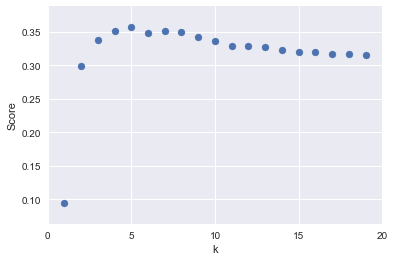

In [304]:
## Fold (a)
scores = []
for k in range(1,20):
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('Score')
plt.scatter(range(1,20), scores)
plt.xticks([0,5,10,15,20]);

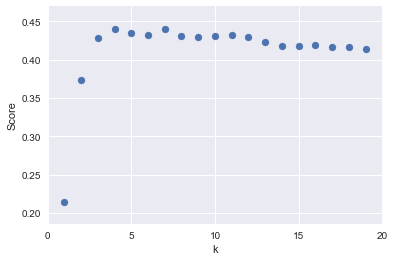

In [337]:
## Fold (b)
scores = []
for k in range(1,20):
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('Score')
plt.scatter(range(1,20), scores)
plt.xticks([0,5,10,15,20]);

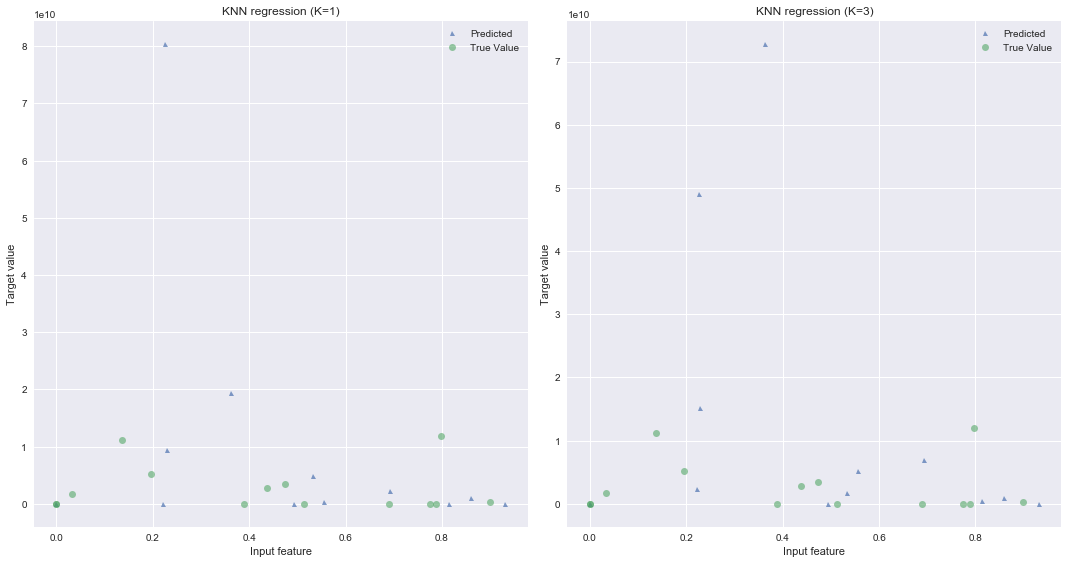

In [320]:
fig, subaxes = plt.subplots(1, 2, figsize=(15,8))

for thisaxis, K in zip(subaxes, [1, 3]):
    knnreg = KNeighborsRegressor(n_neighbors = K).fit(X_train_scaled, y_train)
    #thisaxis.set_xlim([-2.5, 0.75])
    thisaxis.plot(X_test_scaled[5:19,1], knnreg.predict(X_test_scaled[5:19,:]), '^', markersize = 5,
                 label='Predicted', alpha=0.7)
    thisaxis.plot(X_train_scaled[5:19,1], y_train[5:19], 'o', label='True Value', alpha=0.6)
    thisaxis.set_xlabel('Input feature')
    thisaxis.set_ylabel('Target value')
    thisaxis.set_title('KNN regression (K={})'.format(K))
    thisaxis.legend()
plt.tight_layout()

In [328]:
from sklearn.model_selection import cross_val_score

knn=KNeighborsRegressor(n_neighbors=5)
cv_scores = cross_val_score(knn, x, y, cv=50)

print('Cross-validation', cv_scores,'\n\n Mean R2 score: ', np.mean(cv_scores))



Cross-validation [0.51500224 0.46897719 0.53326159 0.38527863 0.37274613 0.57018798
 0.57912074 0.40524995 0.41736436 0.65453231 0.48288725 0.54822528
 0.60310719 0.21918839 0.3401282  0.47316473 0.10042497 0.44660144
 0.38709713 0.60142885 0.14631564 0.40169938 0.41278974 0.19875579
 0.51813467 0.38827609 0.44681023 0.19749871 0.30583356 0.15112152
 0.58416243 0.29844118 0.4734286  0.37553307 0.34736989 0.44593431
 0.4933944  0.26026118 0.49342804 0.41290221 0.41411973 0.43362545
 0.48343431 0.45459273 0.3291034  0.01965729 0.44908868 0.37070439
 0.39631753 0.16926276] 

 Mean R2 score:  0.3995194290876768


## Linear regression

In [255]:
L.info('LinearRegression')

linreg = LinearRegression().fit(X_train, y_train)
print('R-squared score (training): {:.3f}'
      .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
      .format(linreg.score(X_test, y_test)))


LinearRegression


R-squared score (training): 0.122
R-squared score (test): 0.102


In [279]:
X_test_scaled


array([[0.27654561, 0.83986928, 0.        , ..., 0.        , 0.01049247,
        1.        ],
       [0.07748822, 0.47385621, 0.50382406, ..., 0.99977755, 0.05297005,
        1.        ],
       [0.06792348, 0.07843137, 0.06277446, ..., 0.99529156, 0.03892368,
        1.        ],
       ...,
       [0.29068478, 0.83006536, 0.07113531, ..., 0.99126471, 0.05212388,
        1.        ],
       [0.03396174, 0.        , 0.01829066, ..., 0.998688  , 0.83685903,
        0.        ],
       [0.04532853, 0.92156863, 0.01041988, ..., 0.98372492, 0.04366221,
        0.75      ]])

In [277]:
y_predict.shape

(5513,)

In [278]:
y_test.shape

(5513,)

LinearRegression (scaled)


R-squared score (training): 0.122
R-squared score (test): 0.102
Linear model, coefficients:  [ 3.61350081e+10 -1.97841172e+08  5.06676599e+09 -7.93227084e+09
  1.18144428e+09 -1.04131992e+10  5.77339468e+09  2.24860234e+09
 -6.53730179e+09  3.58537545e+09  1.65137880e+10 -4.49326200e+08
 -1.11953914e+10  2.09966693e+09 -7.49413574e+09 -4.49326200e+08]
Mean squared error (dummy): 265670579816508981248.00
Mean squared error (linear model): 238368985474241134592.00
r2_score (dummy): -0.00
r2_score (linear model): 0.10


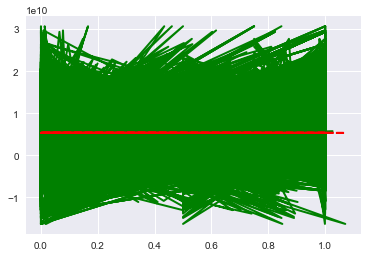

In [274]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor

L.info('LinearRegression')

linreg = LinearRegression().fit(X_train_scaled, y_train)
print('R-squared score (training): {:.3f}'
      .format(linreg.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
      .format(linreg.score(X_test_scaled, y_test)))



lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train_scaled, y_train)

y_predict = linreg.predict(X_test_scaled)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test_scaled)

print('Linear model, coefficients: ', linreg.coef_)
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_mean)))
print("Mean squared error (linear model): {:.2f}".format(mean_squared_error(y_test, y_predict)))
print("r2_score (dummy): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (linear model): {:.2f}".format(r2_score(y_test, y_predict)))

# Plot outputs
#plt.scatter(X_test_scaled, y_test,  color='black');
plt.plot(X_test_scaled, y_predict, color='green', linewidth=2);
plt.plot(X_test_scaled, y_predict_dummy_mean, color='red', linestyle = 'dashed', 
         linewidth=2, label = 'dummy');


In [257]:
L.info('Ridge Regression ')
from sklearn.linear_model import Ridge

linridge = Ridge(alpha=20.0).fit(X_train, y_train)
print('R-squared score (training): {:.3f}'
      .format(linridge.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
      .format(linridge.score(X_test, y_test)))

Ridge Regression 


R-squared score (training): 0.122
R-squared score (test): 0.103


In [258]:
L.info('Polynomial Regression ')
from sklearn.linear_model import LinearRegression
linlasso = Lasso(alpha=2.0, max_iter=10000).fit(X_train_scaled, y_train)
print('R-squared score (training): {:.3f}'
      .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'
      .format(linlasso.score(X_test_scaled, y_test)))

Polynomial Regression 


NameError: name 'Lasso' is not defined

### XG Boost

In [2]:
import xgboost as xgb

In [3]:
from xgboost import XGBRegressor


ImportError: cannot import name 'XGBRegressor'

In [367]:
##with raw data = 0
## 
xgbreg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

xgbreg.fit(X_train_scaled,y_train)

predictions = xgbreg.predict(X_test_scaled)

print(explained_variance_score(predictions,y_test))

In [377]:
import math
testScore=math.sqrt(mean_squared_error(y_test.values,predictions))
print(testScore)

17296123736.70989


In [378]:
predictions


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
## SVM

## Decision Tree

In [283]:
L.info('DecisionTreeRegressor')
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)
reg_tree.fit(X_train_scaled, y_train)
reg_tree_pred = reg_tree.predict(X_test_scaled)

reg_tree_pred

DecisionTreeRegressor


array([3.19224494e+10, 7.24360203e+09, 4.28044528e+09, ...,
       5.81925686e+08, 4.51053278e+07, 4.94282424e+08])

# Evaluation

REGRESSION EVALUATION
* Validation curve: sensitivity to one parameter!
* DummyRegressors: Mean, median, quantile, constant!


In [ ]:
y_pred = knn.predict(X_test_scaled)

##### Coefficient of determination (R2= Explained variation / Total variation) - best is 1.

* R-squared cannot determine whether the coefficient estimates and predictions are biased, which is why you must assess the residual plots.

In [343]:
r2_score(y_test, y_pred)  

0.4137243681314009

#####  Mean squared error (squared diff of target and predicted values - best is 0

In [338]:
mean_squared_error(y_test,y_pred)

1.5931340742800166e+20

#####  Explained variance score - best is 1

In [340]:
from sklearn.metrics import explained_variance_score

explained_variance_score(y_test, y_pred)  

0.41375566033425715

##### Mean absolute error (abs diff of target and predicted values) - best is 0

In [342]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, y_pred)

4731810863.983559

##### Median absolute error (for outliers!) - best is 0


In [344]:
from sklearn.metrics import median_absolute_error

median_absolute_error(y_test, y_pred)

711395388.7071807

### Dummy Regressors

In [286]:
lm_dummy_mean = DummyRegressor(strategy ='mean').fit(X_train_scaled, y_train)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test_scaled)

In [287]:
lm_dummy_med = DummyRegressor(strategy ='median').fit(X_train_scaled, y_train)
y_predict_dummy_med = lm_dummy_med.predict(X_test_scaled)

In [289]:
lm_dummy_q = DummyRegressor(strategy ='quantile',quantile=0.7).fit(X_train_scaled, y_train)
y_predict_dummy_q = lm_dummy_q.predict(X_test_scaled)

In [291]:
lm_dummy_c = DummyRegressor(strategy ='constant',constant=1).fit(X_train_scaled, y_train)
y_predict_dummy_c = lm_dummy_c.predict(X_test_scaled)

In [292]:
print('R-squared score (Dummy Mean): {:.3f}\n'
      .format(linreg.score(X_test_scaled, y_predict_dummy_mean)))

print('R-squared score (Dummy Median): {:.3f}\n'
      .format(linreg.score(X_test_scaled, y_predict_dummy_med)))

print('R-squared score (Dummy Quantile): {:.3f}\n'
      .format(linreg.score(X_test_scaled, y_predict_dummy_q)))

R-squared score (Dummy Mean): 0.000

R-squared score (Dummy Median): 0.000

R-squared score (Dummy Quantile): -3887711661668917386302061778305024.000



In [334]:
for dummy in [DummyRegressor(strategy ='median'),
              DummyRegressor(strategy ='constant',constant=1),
              DummyRegressor(strategy ='quantile',quantile=0.7),
              DummyRegressor(strategy ='mean')]:

    cv_scores = cross_val_score(dummy, x, y, cv=5)

    print('\n\n Mean R2 score: ', np.mean(cv_scores))
    
#R2 negative: fits worse than horizontal line



 Mean R2 score:  -0.10017419886586958


 Mean R2 score:  -0.100174198827549


 Mean R2 score:  -0.0754684403807202


 Mean R2 score:  -0.0002934303505545799


## Statistical significance of results


In [348]:
#use statsmodel to find out what the p-values should be
import statsmodels.api as sm

X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:      calories_per_cell   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     195.6
Date:                Ven, 06 jul 2018   Prob (F-statistic):               0.00
Time:                        13:58:11   Log-Likelihood:            -5.4881e+05
No. Observations:               22051   AIC:                         1.098e+06
Df Residuals:                   22035   BIC:                         1.098e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -5.361e+

In [ ]:
## Doing same with our results

lm = LinearRegression()
lm.fit(X,y)
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X_test)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
print(myDF3)

### K-fold cross validation

K train-test splits, and average score over all splits


In [259]:
## Look @ features' weights
#### Features with very high weight? Data leakage maybe

In [ ]:
knn=KNeighborsRegressor(n_neighbors=5)
cv_scores = cross_val_score(knn, x, y, cv=50)

print('Cross-validation', cv_scores,'\n\n Mean R2 score: ', np.mean(cv_scores))

### Grid Search for parameters selection

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

dataset = load_digits()
X, y = dataset.data, dataset.target == 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = SVC(kernel='rbf')
grid_values = {'gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values)
grid_clf_acc.fit(X_train, y_train)
y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

# alternative metric to optimize over grid parameters: AUC
grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train, y_train)
y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test) 

print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)

## Add climate zone feature

In [379]:
e = pd.read_csv('baseline_regression_data.csv')


In [382]:
e.columns

Index(['Unnamed: 0', 'calories_per_cell', 'precip', 'temperature', 'gdp_2000',
       'minutes_to_market', 'workability', 'toxicity', 'rooting_conditions',
       'protected_areas', 'oxygen_availability', 'nutrient_retention',
       'nutrient_availability', 'excess_salts', 'gdp_gecon', 'slope',
       'altitude', 'climate_zones', 'c3_annual_calories',
       'c3_perennial_calories', 'c4_annual_calories', 'c4_perennial_calories',
       'nitrogen_fixer_calories'],
      dtype='object')

In [383]:
e.climate_zones

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
5           0.0
6           0.0
7           0.0
8           0.0
9           0.0
10          0.0
11          0.0
12          0.0
13          0.0
14          0.0
15          0.0
16          0.0
17          0.0
18          0.0
19          0.0
20          0.0
21          0.0
22          0.0
23          0.0
24          0.0
25          0.0
26          0.0
27          0.0
28          0.0
29          0.0
30          0.0
31          0.0
32          0.0
33          0.0
34          0.0
35          0.0
36          0.0
37          0.0
38          0.0
39          0.0
40          0.0
41          0.0
42          0.0
43          0.0
44          0.0
45          0.0
46          0.0
47          0.0
48          0.0
49          0.0
50          0.0
51          0.0
52          0.0
53          0.0
54          0.0
55          0.0
56          0.0
57          0.0
58          0.0
59          0.0
60          0.0
61          0.0
62      

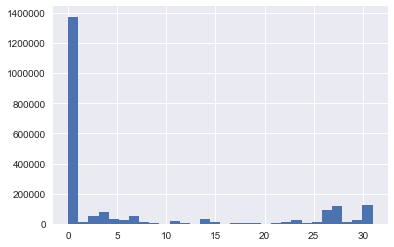

In [385]:
e.climate_zones.hist(bins=30)

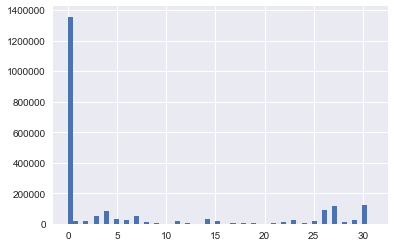

In [386]:
e.climate_zones.hist(bins=60)

In [389]:


climate_zones_map = {1:'Af',2:'Am',3:'Aw',
                     5:'BWk',4:'BWh',7:'BSk',6:'BSh',
                     14:'Cfa',15:'Cfb',16:'Cfc',8:'Csa',
                     9:'Csb',10:'Csc',11:'Cwa',12:'Cwb',13:'Cwc',
                     25:'Dfa',26:'Dfb',27:'Dfc',28:'Dfd',17:'Dsa',18:'Dsb',19:'Dsc',
                     20:'Dsd',21:'Dwa',22:'Dwb',23:'Dwc',24:'Dwd',
                     30:'EF',29:'ET'}




e['climate_zone'] = e['climate_zones_Gridcode'].map(climate_zones_map)
baseline_df = baseline_df.drop(['Unnamed: 0','climate_zones_Gridcode'], axis=1)

Unnamed: 0  calories_per_cell  precip  temperature      gdp_2000  \
0            334361       0.000000e+00   136.0          0.0      0.000000   
1            334362       0.000000e+00   137.0          0.0      0.000000   
2            334363       0.000000e+00   137.0          0.0      0.000000   
3            334364       0.000000e+00   137.0          0.0      0.000000   
4            334365       0.000000e+00   137.0          0.0      0.000000   
5            334366       0.000000e+00   137.0          0.0      0.000000   
6            334367       0.000000e+00   137.0          0.0      0.000000   
7            334368       0.000000e+00   137.0          0.0      0.000000   
8            334369       0.000000e+00   137.0          0.0      0.000000   
9            334370       0.000000e+00   137.0          0.0      0.000000   
10           334371       0.000000e+00   137.0          0.0      0.000000   
11           334372       0.000000e+00   138.0          0.0      0.000000   
12           334373       0.000000e+00   138.0          0.0      0.000000   
13           334374       0.000000e+00   138.0          0.0      0.000000   
14           334378       0.000000e+00   138.0          0.0  28962.040538   
15           334379       0.000000e+00   138.0          0.0  28962.040538   
16           334380       0.000000e+00   138.0          0.0  28962.040538   
17           334381       0.000000e+00   140.0          0.0  28962.040538   
18           334382       0.000000e+00   142.0          0.0  28962.040538   
19           334383       0.000000e+00   149.0          0.0  28962.040538   
20           334384       0.000000e+00   153.0          0.0  28962.040538   
21           334385       0.000000e+00   150.0          0.0  28962.040538   
22           334386       0.000000e+00   150.0          0.0  28962.040538   
23           334387       0.000000e+00   147.0          0.0  28962.040538   
24           334388       0.000000e+00   150.0          0.0  28962.040538   
25           334391       0.000000e+00   138.0          0.0  28962.040538   
26           334392       0.000000e+00   138.0          0.0  28962.040538   
27           334393       0.000000e+00   139.0          0.0  28962.040538   
28           334394       0.000000e+00   142.0          0.0  28962.040538   
29           334395       0.000000e+00   149.0          0.0  28962.040538   
30           334396       0.000000e+00   158.0          0.0  28962.040538   
31           334397       0.000000e+00   168.0          0.0  28962.040538   
32           334398       0.000000e+00   181.0          0.0  28962.040538   
33           334399       0.000000e+00   191.0          0.0  28962.040538   
34           334400       0.000000e+00   196.0          0.0  28962.040538   
35           334401       0.000000e+00   197.0          0.0  28962.040538   
36           334402       0.000000e+00   196.0          0.0  28962.040538   
37           334403       0.000000e+00   188.0          0.0  28962.040538   
38           334404       0.000000e+00   178.0          0.0  28962.040538   
39           334405       0.000000e+00   167.0          0.0  28962.040538   
40           334406       0.000000e+00   155.0          0.0  28962.040538   
41           334407       0.000000e+00   150.0          0.0  28962.040538   
42           334408       0.000000e+00   143.0          0.0  28962.040538   
43           334409       0.000000e+00   148.0          0.0  28962.040538   
44           334410       0.000000e+00   154.0          0.0  28962.040538   
45           334411       0.000000e+00   163.0          0.0  28962.040538   
46           334412       0.000000e+00   181.0          0.0  28962.040538   
47           334413       0.000000e+00   196.0          0.0  28962.040538   
48           334414       0.000000e+00   209.0          0.0  28962.040538   
49           334415       0.000000e+00   217.0          0.0  28962.040538   
50           334416       0.000000e+00   217.0          0.0  28962.040538   
51   

# Resources to explore

* [Data science glossary on Kaggle](https://www.kaggle.com/shivamb/data-science-glossary-on-kaggle)
* [Pandas Data Science](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-1-exploratory-data-analysis-with-pandas-de57880f1a68)

Evaluation metrics / statistical significance of results

* [Evaluations metrics](https://www.analyticsvidhya.com/blog/2016/02/7-important-model-evaluation-error-metrics/)
* [http://blog.minitab.com/blog/adventures-in-statistics-2/how-to-choose-the-best-regression-model](http://blog.minitab.com/blog/adventures-in-statistics-2/how-to-choose-the-best-regression-model)
* [F test](http://blog.minitab.com/blog/adventures-in-statistics-2/what-is-the-f-test-of-overall-significance-in-regression-analysis)
* [on R2](https://stats.stackexchange.com/questions/12900/when-is-r-squared-negative)
* [validation and learning curves](http://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic04_linear_models/topic4_linear_models_part5_valid_learning_curves.ipynb)


Models

* [Gradient boosting](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-10-gradient-boosting-c751538131ac)
* [Viz data analysis](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-2-visual-data-analysis-in-python-846b989675cd)
